In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier,ExtraTreesClassifier
from imblearn.under_sampling import NearMiss
from xgboost import XGBClassifier


In [2]:
# !pip install -U imbalanced-learn

In [3]:
# !pip install xgboost

In [2]:
df=pd.read_csv('/Users/shwethailango/Documents/Work/Solarillion/Flight_delay_pred/Data/data_processed/flight_delay_pred.csv')

In [3]:
df1=df.drop(columns=['FlightDate', 'airport','Unnamed: 0','DayofMonth.1'],axis=1)

### Function for training model for classifers

In [4]:
def train_model(x,y,model,x_test):
    
    model.fit(x,y)
    ypred=model.predict(x_test)
    return ypred


# Feature Selection


### Since there are 30 features, we must select best features as independent variables. There are many ways and here we use,
1.PCA <br> 2. Univariate Selection <br> 3. Feature Importance using ExtraTreesClassifier



## 1.PCA  

In [75]:
#1. Standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(df1)
scaled_data = scaler.fit_transform(df1)#scaled_data:ndarray
std_df1=pd.DataFrame(scaled_data)  #std_df1:df
 

In [76]:
#decomposition for _ features
from sklearn.decomposition import PCA
pca = PCA(n_components=15)

pca.fit(std_df1)
x_pca=pca.fit_transform(std_df1) #x_pca:ndarray
x_df1=pd.DataFrame(x_pca)        #x_df1:df


In [77]:
std_df1.shape,x_df1.shape

((1851436, 27), (1851436, 15))

### Training model

In [78]:
x=np.array(x_df1)
y=np.array(df1[['ArrDel15']])


In [79]:
ypred1,ytest=train_model(x,y,LogisticRegression())

/Users/shwethailango/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


### Validation 

In [80]:
print("Accuracy:",metrics.accuracy_score(ytest, ypred1))
print("Precision:",metrics.precision_score(ytest, ypred1))
print("Recall:",metrics.recall_score(ytest, ypred1))
print("confusion matrix \n",metrics.confusion_matrix(ytest,ypred1))
print("f1 score:",metrics.f1_score(ytest,ypred1))
print("cohen's kappa:",metrics.cohen_kappa_score(ytest,ypred1))


Accuracy: 0.9609246874662424
Precision: 0.8875259890752734
Recall: 0.9313335262240087
confusion matrix 
 [[468002  15093]
 [  8781 119098]]
f1 score: 0.9089022017018354
cohen's kappa: 0.8840486552829601


Text(0, 0.5, 'True positive rate')

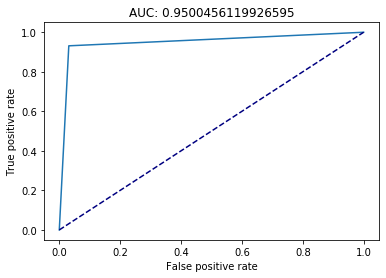

In [81]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(ytest, ypred1, pos_label=1)
auc = roc_auc_score(ytest, ypred1)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], color='navy', linestyle='--', label='random')
plt.title(f'AUC: {auc}')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')

# 2.Univariate and XGBoost
f_classif refers ANOVA test as statistics test

In [82]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif


In [83]:
x=df1.drop(columns=['ArrDel15'],axis=1)
y=df1[['ArrDel15']]


In [84]:
model=SelectKBest(score_func=f_classif,k=17)
kb_fit=model.fit(x,y)

/Users/shwethailango/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [85]:
dfscores = pd.DataFrame(kb_fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']
featureScores=featureScores.nlargest(17,'Score')


In [86]:
kbest=featureScores.iloc[:,0].values

In [90]:
kbest

array(['DepDel15', 'ArrDelayMinutes', 'DepDelayMinutes', 'DepTime',
       'CRSDepTime', 'time', 'CRSArrTime', 'weatherCode', 'precipMM',
       'windspeedKmph', 'WindGustKmph', 'pressure', 'ArrTime',
       'DestAirportID', 'DewPointF', 'cloudcover', 'tempF'], dtype=object)

In [88]:
X=df1[kbest]

In [92]:
X=X.drop(columns=['ArrDelayMinutes','CRSArrTime','ArrTime'],axis=1)
y=df1[['ArrDel15']]

### training model

In [93]:
ypred2,ytest=train_model(X,y,XGBClassifier())

/Users/shwethailango/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


### validation

In [94]:
print("Accuracy:",metrics.accuracy_score(ytest, ypred2))
print("Precision:",metrics.precision_score(ytest, ypred2))
print("Recall:",metrics.recall_score(ytest, ypred2))
print("confusion matrix \n",metrics.confusion_matrix(ytest,ypred2))
print("f1 score:",metrics.f1_score(ytest,ypred2))
print("cohen's kappa:",metrics.cohen_kappa_score(ytest,ypred2))

Accuracy: 0.9178557516359125
Precision: 0.894727215453557
Recall: 0.6885493317902079
confusion matrix 
 [[472735  10360]
 [ 39828  88051]]
f1 score: 0.7782137964558751
cohen's kappa: 0.7288519681923411


# 3.Feature Importance using ExtraTreesClassifier

In [95]:
x=df1.drop(columns=['ArrDel15'],axis=1)
y=df1[['ArrDel15']]


In [96]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(x,y)

/Users/shwethailango/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


ExtraTreesClassifier()

In [97]:
print(model.feature_importances_)

[0.00827238 0.00587469 0.00307327 0.00492839 0.00247641 0.00540377
 0.01061988 0.01482564 0.08666086 0.38484705 0.00782282 0.02073021
 0.02562829 0.35342601 0.00616499 0.00611142 0.00521277 0.00585751
 0.00587019 0.00358516 0.005829   0.0059021  0.00597183 0.00282543
 0.00602912 0.00605079]


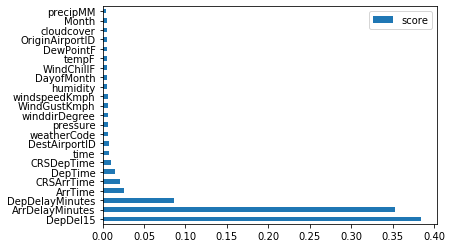

In [99]:
feat_importances = pd.DataFrame(model.feature_importances_, index=x.columns,columns=['score'])
feat_importances.nlargest(23,'score').plot(kind='barh')
plt.show()

In [100]:
f_imp=feat_importances.sort_values(by='score',ascending=False).iloc[0:19,:].index

In [5]:
f_imp=['DepDelayMinutes', 'DepTime', 'CRSDepTime', 'time', 'DestAirportID', 'OriginAirportID','DayofMonth','Quarter','Month'
       ,'weatherCode', 'pressure', 'winddirDegree', 'WindGustKmph',
       'windspeedKmph', 'WindChillF', 'DewPointF', 'humidity','tempF']

In [6]:
x=np.array(df1[f_imp])
y=np.array(df1['ArrDel15'])

# SAMPLING IMBALANCED DATA

In [36]:
df1['ArrDel15'].value_counts()

0.0    1463378
1.0     388058
Name: ArrDel15, dtype: int64

Text(0, 0.5, 'Frequency')

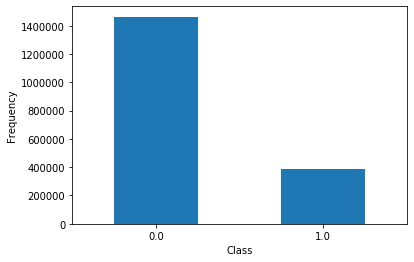

In [37]:
count_classes = pd.value_counts(df1['ArrDel15'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xlabel("Class")
plt.ylabel("Frequency")


## Techniques to sample unbalanced data, 
1.UnderSampling(NearMiss)<br>
2.Oversampling(ADASYN)<br>
3.Combine sampling(SMOTETomek)<br>
4.AdaBoost<br>
5.Bagging<br>

In [8]:
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.20, random_state=42)


## 1.Under sampling

In [9]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
x_us, y_us = rus.fit_resample(x_train, y_train) # only training set is sampled

Text(0, 0.5, 'Frequency')

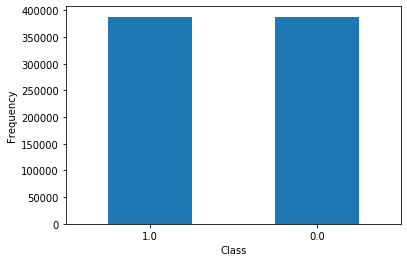

In [41]:
count_classes = pd.value_counts(y_us, sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.xlabel("Class")

plt.ylabel("Frequency")


## 2.Combined sampling

In [128]:
from imblearn.combine import SMOTETomek
smk = SMOTETomek(random_state=42)
x_os,y_os=smk.fit_sample(x_train,y_train)

Text(0, 0.5, 'Frequency')

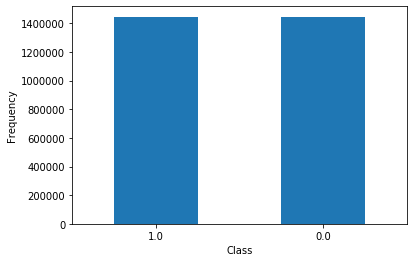

In [119]:
count_classes = pd.value_counts(y_os, sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.xlabel("Class")

plt.ylabel("Frequency")


## 3.Over Sampling

In [141]:
from imblearn.over_sampling import ADASYN

ada = ADASYN(random_state=42)
x_as, y_as = ada.fit_resample(x_train, y_train)

Text(0, 0.5, 'Frequency')

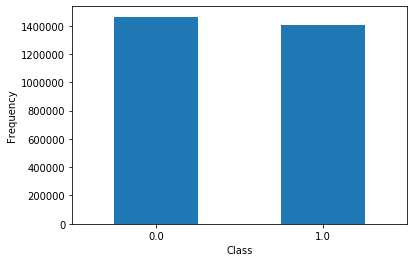

In [120]:
count_classes = pd.value_counts(y_as, sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.xlabel("Class")

plt.ylabel("Frequency")


## Adaboost

In [112]:
xtrain,xtest,ytrain,ytest=train_test_split(x,y,random_state=42,test_size=0.2)

In [113]:
from sklearn.ensemble import AdaBoostClassifier

boost_clf = AdaBoostClassifier()

boost_clf.fit(xtrain, ytrain)

ypred = boost_clf.predict(xtest)



In [114]:
print("Accuracy:",metrics.accuracy_score(ytest, ypred))
print("Precision:",metrics.precision_score(ytest, ypred))
print("Recall:",metrics.recall_score(ytest, ypred))
print("Confusion matrix")
cnf_matrix = metrics.confusion_matrix(ytest, ypred)
cnf_matrix

Accuracy: 0.9161112431404744
Precision: 0.888857366954258
Recall: 0.685795586228208
Confusion matrix


array([[285962,   6660],
       [ 24403,  53263]])

In [115]:
print(metrics.classification_report(ytest,ypred))

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95    292622
         1.0       0.89      0.69      0.77     77666

    accuracy                           0.92    370288
   macro avg       0.91      0.83      0.86    370288
weighted avg       0.91      0.92      0.91    370288



## Bagging

In [116]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=0.2)

In [117]:
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier()

bagging_clf.fit(x_train, y_train)
y_pred = bagging_clf.predict(x_test)



In [118]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.9116957611372769
Precision: 0.8711701003697834
Recall: 0.6794736435505884
Confusion matrix
[[284818   7804]
 [ 24894  52772]]
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.95    292622
         1.0       0.87      0.68      0.76     77666

    accuracy                           0.91    370288
   macro avg       0.90      0.83      0.85    370288
weighted avg       0.91      0.91      0.91    370288



## XGBoost (sampled vs unsampled)

#### 1.Unsampled

In [106]:
x=np.array(df1[f_imp])
y=np.array(df1['ArrDel15'])

In [107]:
ypred=train_model(x_train,y_train,XGBClassifier(),x_test)

In [108]:
print("Accuracy:",metrics.accuracy_score(y_test, ypred))
print("Precision:",metrics.precision_score(y_test, ypred))
print("Recall:",metrics.recall_score(y_test, ypred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test, ypred))
print(metrics.classification_report(y_test, ypred))

Accuracy: 0.9193697276807197
Precision: 0.8990416827401376
Recall: 0.6925374768335693
Confusion matrix
[[473150   9945]
 [ 39318  88561]]
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95    483095
         1.0       0.90      0.69      0.78    127879

    accuracy                           0.92    610974
   macro avg       0.91      0.84      0.87    610974
weighted avg       0.92      0.92      0.92    610974



#### 2. Undersampled

In [127]:
y_pred=train_model(x_us,y_us,XGBClassifier(),x_test)

In [45]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Confusion matrix")
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.8818635087596001
Precision: 0.9220669500073277
Recall: 0.8344672086382574
Confusion matrix
              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89    127945
         1.0       0.92      0.83      0.88    128174

    accuracy                           0.88    256119
   macro avg       0.89      0.88      0.88    256119
weighted avg       0.89      0.88      0.88    256119



#### 3.Oversampled

In [142]:
y_pred3=train_model(x_as,y_as,XGBClassifier(),x_test)

In [143]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred3))
print("Precision:",metrics.precision_score(y_test, y_pred3))
print("Recall:",metrics.recall_score(y_test, y_pred3))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test, y_pred3))
print(metrics.classification_report(y_test, y_pred3))

Accuracy: 0.9180394719785681
Precision: 0.8917294478019704
Recall: 0.6934308448999562
Confusion matrix
[[286083   6539]
 [ 23810  53856]]
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95    292622
         1.0       0.89      0.69      0.78     77666

    accuracy                           0.92    370288
   macro avg       0.91      0.84      0.86    370288
weighted avg       0.92      0.92      0.91    370288



#### 4.Combined

In [129]:
y_pred4=train_model(x_os,y_os,XGBClassifier(),x_test)

In [130]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred4))
print("Precision:",metrics.precision_score(y_test, y_pred4))
print("Recall:",metrics.recall_score(y_test, y_pred4))
print("Confusion matrix")
cnf_matrix = metrics.confusion_matrix(y_test, y_pred4)
print(metrics.classification_report(y_test, y_pred4))

Accuracy: 0.9183419392472886
Precision: 0.8937127488253948
Recall: 0.6931089537249246
Confusion matrix
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95    292622
         1.0       0.89      0.69      0.78     77666

    accuracy                           0.92    370288
   macro avg       0.91      0.84      0.87    370288
weighted avg       0.92      0.92      0.91    370288



## Decision Tree (sampled vs unsampled)

#### 1. Unsampled

In [109]:
x=np.array(df1[f_imp])
y=np.array(df1['ArrDel15'])

In [110]:
ypred=train_model(x_train,y_train,DecisionTreeClassifier(),x_test)

In [111]:
print("Accuracy:",metrics.accuracy_score(y_test, ypred))
print("Precision:",metrics.precision_score(y_test, ypred))
print("Recall:",metrics.recall_score(y_test, ypred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test, ypred))
print(metrics.classification_report(y_test, ypred))

Accuracy: 0.8684673979580145
Precision: 0.6787471598176265
Recall: 0.7054715786016469
Confusion matrix
[[440396  42699]
 [ 37664  90215]]
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92    483095
         1.0       0.68      0.71      0.69    127879

    accuracy                           0.87    610974
   macro avg       0.80      0.81      0.80    610974
weighted avg       0.87      0.87      0.87    610974



### 2. Undersampled

In [17]:
ypred2=train_model(x_us,y_us,DecisionTreeClassifier(),x_test)

In [18]:
print("Accuracy:",metrics.accuracy_score(y_test, ypred2))
print("Precision:",metrics.precision_score(y_test, ypred2))
print("Recall:",metrics.recall_score(y_test, ypred2))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test, ypred2))
print(metrics.classification_report(y_test, ypred2))

Accuracy: 0.7915109320312838
Precision: 0.5018718148956212
Recall: 0.8026420827646589
Confusion matrix
[[230749  61873]
 [ 15328  62338]]
              precision    recall  f1-score   support

         0.0       0.94      0.79      0.86    292622
         1.0       0.50      0.80      0.62     77666

    accuracy                           0.79    370288
   macro avg       0.72      0.80      0.74    370288
weighted avg       0.85      0.79      0.81    370288



### 3.Oversampled

In [144]:
ypred3=train_model(x_as,y_as,DecisionTreeClassifier(),x_test)

In [145]:
print("Accuracy:",metrics.accuracy_score(y_test, ypred3))
print("Precision:",metrics.precision_score(y_test, ypred3))
print("Recall:",metrics.recall_score(y_test, ypred3))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test, ypred3))
print(metrics.classification_report(y_test, ypred3))

Accuracy: 0.8661204251825606
Precision: 0.672678321162499
Recall: 0.7045167769680426
Confusion matrix
[[265997  26625]
 [ 22949  54717]]
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.91    292622
         1.0       0.67      0.70      0.69     77666

    accuracy                           0.87    370288
   macro avg       0.80      0.81      0.80    370288
weighted avg       0.87      0.87      0.87    370288



### 4.combined

In [54]:
ypred4=train_model(x_os,y_os,DecisionTreeClassifier(),x_test)

In [55]:
print("Accuracy:",metrics.accuracy_score(y_test, ypred4))
print("Precision:",metrics.precision_score(y_test, ypred4))
print("Recall:",metrics.recall_score(y_test, ypred4))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test, ypred4))
print(metrics.classification_report(y_test, ypred4))

Accuracy: 0.9163068504400548
Precision: 0.9133600291226793
Recall: 0.9198697737171685
Confusion matrix
[[435681  41650]
 [ 38248 439075]]
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92    477331
         1.0       0.91      0.92      0.92    477323

    accuracy                           0.92    954654
   macro avg       0.92      0.92      0.92    954654
weighted avg       0.92      0.92      0.92    954654



## Extra Trees Classifier

#### 1.Undersampled

In [13]:
ypred_1=train_model(x_us,y_us,ExtraTreesClassifier(),x_test)

In [14]:
print("Accuracy:",metrics.accuracy_score(y_test, ypred_1))
print("Precision:",metrics.precision_score(y_test, ypred_1))
print("Recall:",metrics.recall_score(y_test, ypred_1))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test, ypred_1))
print(metrics.classification_report(y_test, ypred_1))

Accuracy: 0.8785566910080802
Precision: 0.6731044121851275
Recall: 0.8185048798702135
Confusion matrix
[[261749  30873]
 [ 14096  63570]]
              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92    292622
         1.0       0.67      0.82      0.74     77666

    accuracy                           0.88    370288
   macro avg       0.81      0.86      0.83    370288
weighted avg       0.89      0.88      0.88    370288



#### 2.Oversampled

In [146]:
ypred_2=train_model(x_as,y_as,ExtraTreesClassifier(),x_test)

In [147]:
print("Accuracy:",metrics.accuracy_score(y_test, ypred_2))
print("Precision:",metrics.precision_score(y_test, ypred_2))
print("Recall:",metrics.recall_score(y_test, ypred_2))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test, ypred_2))
print(metrics.classification_report(y_test, ypred_2))

Accuracy: 0.9080742557144709
Precision: 0.8133088203610875
Recall: 0.8317281693405094
Confusion matrix
[[279624  12998]
 [ 21041  56625]]
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94    292622
         1.0       0.81      0.73      0.77     77666

    accuracy                           0.91    370288
   macro avg       0.87      0.84      0.86    370288
weighted avg       0.91      0.91      0.91    370288



#### 3.combined

In [135]:
ypred_3=train_model(x_os,y_os,ExtraTreesClassifier(),x_test)

In [136]:
print("Accuracy:",metrics.accuracy_score(ytest, ypred_3))
print("Precision:",metrics.precision_score(ytest, ypred_3))
print("Recall:",metrics.recall_score(ytest, ypred_3))
print("Confusion matrix")
print(metrics.confusion_matrix(ytest, ypred_3))
print(metrics.classification_report(ytest, ypred_3))

Accuracy: 0.9111988506243789
Precision: 0.8283477036776351
Recall: 0.7273452991012799
Confusion matrix
[[280916  11706]
 [ 21176  56490]]
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94    292622
         1.0       0.83      0.73      0.77     77666

    accuracy                           0.91    370288
   macro avg       0.88      0.84      0.86    370288
weighted avg       0.91      0.91      0.91    370288



## GradientBoostingClassifier

#### 1.Undersampled

In [15]:
y_pred_1=train_model(x_us,y_us,GradientBoostingClassifier(),x_test)

In [16]:
print("Accuracy:",metrics.accuracy_score(y_test,y_pred_1))
print("Precision:",metrics.precision_score(y_test, y_pred_1))
print("Recall:",metrics.recall_score(y_test, y_pred_1))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test, y_pred_1))
print(metrics.classification_report(y_test, y_pred_1))

Accuracy: 0.8959053493496953
Precision: 0.7354955996195567
Recall: 0.7865861509540855
Confusion matrix
[[270652  21970]
 [ 16575  61091]]
              precision    recall  f1-score   support

         0.0       0.94      0.92      0.93    292622
         1.0       0.74      0.79      0.76     77666

    accuracy                           0.90    370288
   macro avg       0.84      0.86      0.85    370288
weighted avg       0.90      0.90      0.90    370288



#### 2.Oversampled

In [148]:
y_pred_2=train_model(x_as,y_as,GradientBoostingClassifier(),x_test)

In [149]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_2))
print("Precision:",metrics.precision_score(y_test, y_pred_2))
print("Recall:",metrics.recall_score(y_test, y_pred_2))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test, y_pred_2))
print(metrics.classification_report(y_test, y_pred_2))

Accuracy: 0.9005476818044333
Precision: 0.7603861161408788
Recall: 0.7677877063322432
Confusion matrix
[[273831  18791]
 [ 18035  59631]]
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94    292622
         1.0       0.76      0.77      0.76     77666

    accuracy                           0.90    370288
   macro avg       0.85      0.85      0.85    370288
weighted avg       0.90      0.90      0.90    370288



#### 3.combined

In [139]:
y_pred_3=train_model(x_os,y_os,GradientBoostingClassifier(),x_test)

In [140]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_3))
print("Precision:",metrics.precision_score(y_test, y_pred_3))
print("Recall:",metrics.recall_score(y_test, y_pred_3))
print("Confusion matrix")
print(metrics.confusion_matrix(y_test, y_pred_3))
print(metrics.classification_report(y_test, y_pred_3))

Accuracy: 0.910515598669144
Precision: 0.8180740275138927
Recall: 0.737336801174259
Confusion matrix
[[279887  12735]
 [ 20400  57266]]
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94    292622
         1.0       0.82      0.74      0.78     77666

    accuracy                           0.91    370288
   macro avg       0.88      0.85      0.86    370288
weighted avg       0.91      0.91      0.91    370288



#### 4.Unsampled

In [72]:
y_pred_4=train_model(x_train,y_train,GradientBoostingClassifier(),x_test)

In [74]:
print("Accuracy:",metrics.accuracy_score(ytest, ypred4))
print("Precision:",metrics.precision_score(ytest, ypred4))
print("Recall:",metrics.recall_score(ytest, ypred4))
print("Confusion matrix")
print(metrics.confusion_matrix(ytest, ypred4))
print(metrics.classification_report(ytest, ypred4))

Accuracy: 0.9172059694847898
Precision: 0.8956733624096485
Recall: 0.6841154528890592
Confusion matrix
[[472905  10190]
 [ 40395  87484]]
              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95    483095
         1.0       0.90      0.68      0.78    127879

    accuracy                           0.92    610974
   macro avg       0.91      0.83      0.86    610974
weighted avg       0.92      0.92      0.91    610974

